In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [185]:
# Loading the data
data = pd.read_csv('YearPredictionMSD.csv')

In [186]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [187]:
data.shape

(515345, 91)

In [188]:
# Splitting the training data and test data for predictor and target variables as per the given details
X_train = data.iloc[:463715, 1:]
y_train = data.iloc[:463715, 0]
X_test = data.iloc[463715:, 1:]
y_test = data.iloc[463715:, 0]

**Part 1: Transform the predictors**

In [189]:
best_transformations = {}
names = ['no_transform', 'log', 'exp', 'inv', 'square', 'sqrt', 'cns', 'range', 'int_bin', 'quant_bin']
transform_counts = {name: 0 for name in names}

# Applying the different transformations to each predictor variable
for n, predictor in X_train.items():
  log_transform = np.log(predictor)
  exp_transform = np.exp(predictor)
  inv_transform = 1 / predictor
  square_transform = predictor ** 2
  sqrt_transform = np.sqrt(predictor)
  cns_transform = (predictor - predictor.mean()) / predictor.std()
  range_transform = (predictor - predictor.min()) / (predictor.max() - predictor.min())
  int_bin_transform = pd.cut(predictor, bins=10, labels=False)
  quant_bin_transform = pd.qcut(predictor, q=10, labels=False)

  transforms = [predictor, log_transform, exp_transform, inv_transform, square_transform, sqrt_transform, cns_transform, range_transform, int_bin_transform, quant_bin_transform]
  
  # print(f"For the predictor variable {n}:")
  # Finding the correlation coefficient and R-squared score of the transformed predictor with the target variable
  r2_scores = []
  for i, transform in enumerate(transforms):
      # print('Correlation coefficient between {} transformed predictor and target variables: {:.3f}'.format(names[i], pd.Series(np.nan_to_num(transform)).corr(y_train)))
      transformed = sm.add_constant(np.nan_to_num(transform).reshape(-1, 1))
      model = sm.OLS(np.nan_to_num(y_train).reshape(-1, 1), transformed).fit()
      r_squared = model.rsquared
      r2_scores.append(r_squared)
      # print(f"R-squared score for {names[i]}: {r_squared:.4f}")
  
  best_index = np.argmax(r2_scores)
  best_transformations[n] = names[best_index]
  transform_counts[names[best_index]] += 1
  # print(f"Best transformation for {n}: {names[best_index]} (R-squared score: {r2_scores[best_index]:.2f})")


In [190]:
# table listing the predictor variable and the transform selected
table = pd.DataFrame(best_transformations.items(), columns=['Predictor Variable', 'Transform Selected'])

# Summary table showing how many times each transform was used
summary_table = pd.DataFrame({'Transform': list(transform_counts.keys()), 'Count': list(transform_counts.values())})


# print the table listing the predictor variable and the transform selected
print("\nTable: Predictor Variable vs Transform Selected")
print(table)

# print the summary table showing how many times each transform was used
print("\nSummary Table: Count of Each Transform Used")
print(summary_table)


Table: Predictor Variable vs Transform Selected
   Predictor Variable Transform Selected
0                   1          quant_bin
1                   2             square
2                   3          quant_bin
3                   4             square
4                   5             square
..                ...                ...
85                 86          quant_bin
86                 87          quant_bin
87                 88          quant_bin
88                 89               sqrt
89                 90          quant_bin

[90 rows x 2 columns]

Summary Table: Count of Each Transform Used
      Transform  Count
0  no_transform      6
1           log      6
2           exp      0
3           inv      2
4        square     10
5          sqrt     22
6           cns      6
7         range      1
8       int_bin      7
9     quant_bin     30


In [191]:
def apply_transformation(X, best_transformations):
    transformation_dict = {'log': np.log,
                          'exp': np.exp,
                          'inv': lambda x: 1/x,
                          'square': lambda x: x**2,
                          'sqrt': np.sqrt,
                          'cns': lambda x: (x - x.mean()) / x.std(),
                          'range': lambda x: (x - x.min()) / (x.max() - x.min()),
                          'int_bin': lambda x: pd.cut(x, bins=10, labels=False),
                          'quant_bin': lambda x: pd.qcut(x, q=10, labels=False)}

    X_transformed = pd.DataFrame()

    for col in X.columns:
        transformation_name = best_transformations.get(col, 'no_transform')
        transformation_func = transformation_dict.get(transformation_name, lambda x: x)
        X_transformed[col] = transformation_func(X[col])
        
    return X_transformed


In [192]:
X_train_transformed = apply_transformation(X_train, best_transformations)
X_test_transformed = apply_transformation(X_test, best_transformations)

**Part 2: Principal Component Analysis**

In [193]:
def pca(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    n_components = X_train.shape[1]
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)

    # plot the cumulative explained variance ratio vs. number of components
    cumulative_var_ratio = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, n_components+1), cumulative_var_ratio, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.show()

    # find the number of components needed to explain at least 95% of the variance
    n_components = np.argmax(cumulative_var_ratio >= 0.95) + 1
    print(f"Number of components to explain at least 95% variance: {n_components}")

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(scaler.transform(X_test))

    return X_train_pca, X_test_pca

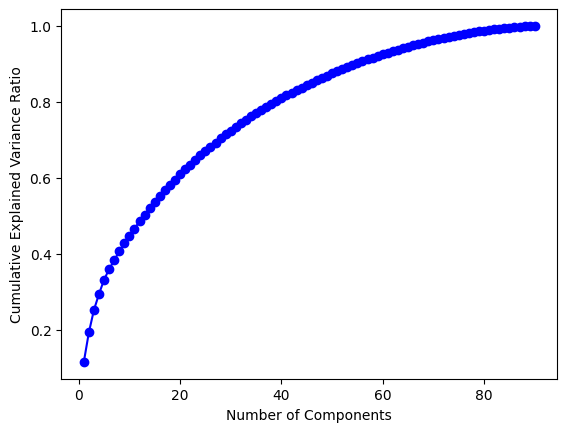

Number of components to explain at least 95% variance: 67


In [194]:
X_train_pca, X_test_pca = pca(X_train, X_test)

**Part 3: Regression Models**

In [195]:
# Build and train linear regression model on untransformed predictors
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test set and print RMSE
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Untransformed predictors RMSE:", rmse)

Untransformed predictors RMSE: 9.510160707488621


In [196]:
# Build and train a model with transformed predictors

# Train linear regression model on transformed predictors
model_transformed = LinearRegression()
model_transformed.fit(np.nan_to_num(X_train_transformed), y_train)

# Make predictions on test set and print RMSE
yt_pred = model_transformed.predict(np.nan_to_num(X_test_transformed))
rmse_transformed = mean_squared_error(y_test, yt_pred, squared=False)
print("Transformed predictors RMSE:", rmse_transformed)

Transformed predictors RMSE: 9.85039633006162


In [197]:
# Step 3: Build and train a model with principal components

model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

# Make predictions on test set and print RMSE
yp_pred = model_pca.predict(X_test_pca)
rmse_pca = mean_squared_error(y_test, yp_pred, squared=False)
print("PCA predictors RMSE:", rmse_pca)

PCA predictors RMSE: 9.853499454345094
